In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
nside = 4
from mpl_toolkits import mplot3d
from matplotlib import ticker
import healpy as hp
import matplotlib
import copy
from matplotlib import rc
import sys
sys.path.insert(0, '../src/')
from AMC_Density_Evolution import *

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})

In [2]:
def theta_cut(arrayVals, Theta, thetaV, eps=0.01):
    if (thetaV - eps) < 0:
        condition1 = Theta < (thetaV + eps)
        condition2 = Theta > np.pi + (thetaV - eps)
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    elif (thetaV - eps) > np.pi:
        condition1 = Theta < (thetaV + eps) - np.pi
        condition2 = Theta > (thetaV - eps)
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    else:
        condition1 = Theta < (thetaV + eps)
        condition2 = Theta > (thetaV - eps)
    
        jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
    return arrayVals[jointC]
def phi_cut(arrayVals, Phi, phiV, eps=0.01):
    if (phiV - eps) < -np.pi:
        condition1 = Phi < phiV + eps
        condition2 = Phi > 2 * np.pi + phiV - eps
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    elif (phi_list[j] + eps) > np.pi:
        condition1 = Phi < phiV + eps - 2 * np.pi
        condition2 = Phi > phiV - eps
        jointC = np.any(np.column_stack((condition1, condition2)), axis=1)
    else:
        condition1 = Phi < phiV + eps
        condition2 = Phi > phiV - eps
        jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
    return arrayVals[jointC]

def diff_power_curve(arrayVals, ThetaVals, mass, period, binTot=300, eps_theta=0.01):
    thetaL = np.linspace(1e-4, np.pi-1e-4, binTot)
    rate = np.zeros(binTot)
    for i in range(len(thetaL)):
        new_arr = theta_cut(arrayVals, ThetaVals, thetaL[i], eps=eps_theta)
        rate[i] = np.sum(new_arr[:,5]) * mass / ( np.sin(thetaL[i]) * 2 * np.sin(eps_theta)) / period  # eV / s
    return np.column_stack((thetaL, rate))
def extract_file_params(fileN):
    tag1 = fileN.find('rotPulsar_') + len('rotPulsar_')
    tag2 = fileN.find('_B0_')
    period = 2*np.pi / float(fileN[tag1:tag2])
    
    tag1 = fileN.find('_MassAx_') + len('_MassAx_')
    tag2 = fileN.find('_AxionG_')
    mass = float(fileN[tag1:tag2])
    
    tag1 = fileN.find('ThetaM_') + len('ThetaM_')
    tag2 = fileN.find('_rotPulsar')
    thetaM = float(fileN[tag1:tag2])
    return mass, period, thetaM
def generate_diff_power_plots(fileList,  b_param_list, time, labels, cutN=1.0, ymax=1e40, ymin=1e30, eps_theta=0.01, binTot=300, sve=False, fileTag="DiffPower_", SuppFactor=[1e-6, 1e14, 1, 0], den_avg=[False, True], NS_vel_T=[0.0, 0.0, 0.0], is_axionstar=False, sve_flux=False):
    fig, ax = plt.subplots(figsize=(10,6))
    colorL = ["#73AB84", "#79C7C5", "#6B0504", "#94849B", "#FFCAAF"]
    for i,fileN in enumerate(fileList):
        b_param = b_param_list[i]
        file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T[i], is_axionstar=is_axionstar)
        
        print(np.median(den))
        # ASSUME COUPLING 1e-14 1/GeV
        # probs = file_use[:,16]
        # probs = (1 - np.exp(-probs)) * np.exp(-probs)
        
        # file_use[:, 5] *= probs / file_use[:,16]
        
        file_use[:, 5] *= SuppFactor[i]
        if den_avg[i]:
            file_use[:, 5] *= np.median(den) 
        else:
            
            file_use[:, 5] *= den
            # pass
            
        ThetaVals = file_use[:,2]
        #mass, period, thetaM = extract_file_params(fileN)
        mass = 1e-5
        period = 1
        thetaM = 0.0

        vals = diff_power_curve(file_use, ThetaVals, mass, period, binTot=binTot, eps_theta=eps_theta)
        vals[0,1] = vals[1,1]
        vals[-1,1] = vals[-2,1]

        vals[vals[:,1] <= 0, 1] = 1e10
        plt.plot(vals[:,0], vals[:,1], label=labels[i], c=colorL[i])
        
        if sve_flux:
            np.save("testF_PointSource.npy", vals)
        
    ax.tick_params(direction='in', length=8, width=1, labelsize=18)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=3, width=1, labelsize=12)
    ax.legend(loc='upper right',fontsize=14)
    plt.yscale("log")
    plt.xlim([0, np.pi])
    plt.ylim([ymin, ymax])
    plt.xlabel(r'$\theta$ \hspace{.5cm} [rad.]', fontsize=24);
    plt.ylabel(r'$dP / d\theta$ \hspace{.5cm} [eV / s]', fontsize=24);
    
    if sve:
        #plt.savefig("/Users/samuelwitte/Desktop/Magnetized_Plasma/neutron-star-ray-tracing/plots/"+fileTag + ".png",dpi=200)
        np.savetxt("/Users/samuelwitte/Desktop/DiffPower.dat", vals)
    return

@jit(nopython=True)
def ThetaPhi(data):
    Tkf = data[:, 0]
    Pkf = data[:, 1]
    TXf = data[:, 2]
    PXf = data[:, 3]
    rX = data[:, 4]

    Theta = np.zeros(len(rX))
    Phi = np.zeros(len(rX))
    #r_proj = np.max(rX)
    r_proj = 1e10
    for i in range(len(rX)):
        xx = np.array([rX[i] * np.cos(PXf[i]) * np.sin(TXf[i]), rX[i] * np.sin(PXf[i]) * np.sin(TXf[i]), rX[i] * np.cos(TXf[i])])
        vv = np.array([ np.cos(Pkf[i]) * np.sin(Tkf[i]), np.sin(Pkf[i]) * np.sin(Tkf[i]), np.cos(Tkf[i])])
        tproj = -np.sum(xx*vv) + np.sqrt(4*np.sum(xx*vv)**2. - 4 * (rX[i]**2. - r_proj**2.))/2.
        Phi[i] = np.arctan2((vv[1] * tproj + xx[1]), (vv[0] * tproj + xx[0]))
        Theta[i] = np.arccos((vv[2] * tproj + xx[2]) / r_proj)
    return Theta,Phi

def ShowPlots(fileN, nside, b_param, time, maxF=None, minF=None, den_avg=False, NS_vel_T=0.0, is_axionstar=False, tag="", sve=False):
    file_use, den = eval_density_3d(fileN, b_param, time, NS_vel_T, is_axionstar=is_axionstar)
    print(np.max(den))
    if den_avg:
        file_use[:, 5] *= np.median(den) 
    else:
        file_use[:, 5] *= den

    # ASSUME COUPLING 1e-14 1/GeV
    #probs = file_use[:,16]
    #probs = (1 - np.exp(-probs)) * np.exp(-probs)
    #file_use[:, 5] *= probs / file_use[:,16]
    
    
    Theta,Phi = ThetaPhi(file_use)
    rateT = np.sum(file_use[:, 5])
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)
    ratVs = np.zeros(hp.nside2npix(nside))    
    MinRate = 1e-12
    
    for i in range(indxs):
        rel_rows = file_use[pixel_indices == i]
        if len(rel_rows) == 0:
            ratVs[i] = MinRate
        else:
            ratVs[i] = np.sum(rel_rows[:, 5]) / rateT 
            if ratVs[i] == 0:
                ratVs[i] = MinRate
    cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))    
    if maxF == None:
        maxF = np.max(np.log10(ratVs))
    if minF == None:
        minF = np.min(np.log10(ratVs))
        
    hp.mollview(np.log10(ratVs), min=minF,max=maxF,title="", unit=r"$\log_{{10}}\left(R_{{i}}/R_{{\rm tot}} \right)$",xsize=2000, cmap=cmap)
    hp.graticule(dmer=360,dpar=360,alpha=0) 
    fontS = 20
    ax = plt.gca()
    im = ax.get_images()[0]
    fig = plt.gcf()
    matplotlib.rcParams.update({'font.size':fontS})
    
    fig.axes[1].texts[0].set_fontsize(20);
    if sve:
        plt.savefig("/Users/samuelwitte/Desktop/SkyMap_Flux_"+tag+".png", dpi=200)
    
def histo_conv_probs(fileN):
    
    file_use = np.load(fileN)
        
    # ASSUME COUPLING 1e-14 1/GeV
    probs = file_use[:,16] * (1e-14 / 1e-12)**2
    plt.hist(probs, bins=np.logspace(-10, 5, 300), histtype='step')
    plt.yscale("log")
    plt.xscale("log")

    return

In [3]:
rho_amc = (3*1e-10 / (4*np.pi * (3.06e9 / 3.086e13)**3))  #
transitT = AMC_CrossingTime(0.0, 1e-10, 0.00067, rho_amc)

622985003.8843144 106726113797889.55
9171.310804913657
514202292.7257454 6649981297.014046
9717.091474425397
599924647.6041784 936990596.9625323
9718.140975026206


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


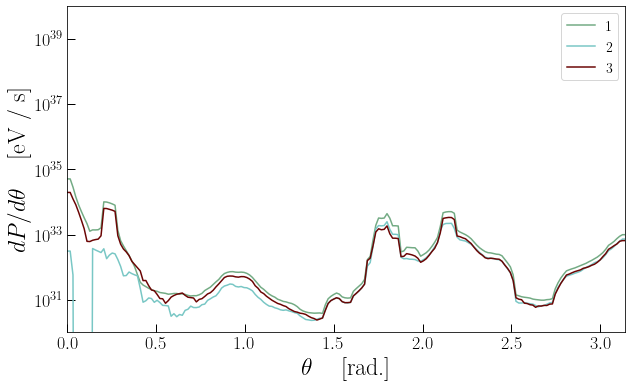

In [4]:
fileN1 = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-10_Rmc_3.0e9___AMC_NoTrace__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
fileN2 = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_100000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-10_Rmc_3.12e9__trace_trags__thetaCN___callback__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
fileN3 = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_50000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-10_Rmc_3.12e9__trace_trags__thetaCN___PointSource__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3]
labels = [r"1", "2", "3"]
SuppFactor = [1, 1, 1]
fileTag = ""
b_param = [np.asarray([6.23e8, 0.0, 0.0]), np.asarray([6.11e8, 0.0, 0.0]), np.asarray([6.11e8, 0.0, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = True
NS_vel_T = np.pi
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.04, binTot=200, sve=False, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e40, sve_flux=sve_flux)

141356561.6653731 6616139390.552228
9717.988476087312


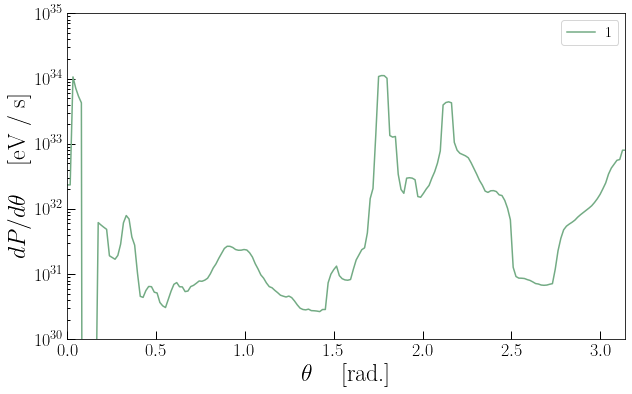

In [17]:
fileN1 = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_500000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-10_Rmc_3.12e9__trace_trags__thetaCN___callback__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
fileList = [fileN1]
labels = [r"1", "2", "3"]
SuppFactor = [1, 1, 1]
fileTag = ""
b_param = [np.asarray([6.11e8, 0.0, 0.0]), np.asarray([6.11e8, 0.0, 0.0]), np.asarray([6.11e8, 0.0, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = True
NS_vel_T = np.pi
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.03, binTot=200, sve=False, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e35, ymin=1e30, sve_flux=sve_flux)

In [1]:
fileN = "data_paper/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_5000000_NS_Mag_0.00033_NS_Theta_0.0_Mmc_1.0e-12_Rmc_1.86e9__trace_trags__thetaCN__fixed_time_0.0__NFW__.npz"
nside=32
b_param = np.asarray([1.0e8, 1.0e8, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = np.pi
tag = "_AMC_b_6.1e8km_"
sve=False
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T, tag=tag, sve=sve)

NameError: name 'np' is not defined

610985009.019656 106726113797817.02
8850.252865641187


/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


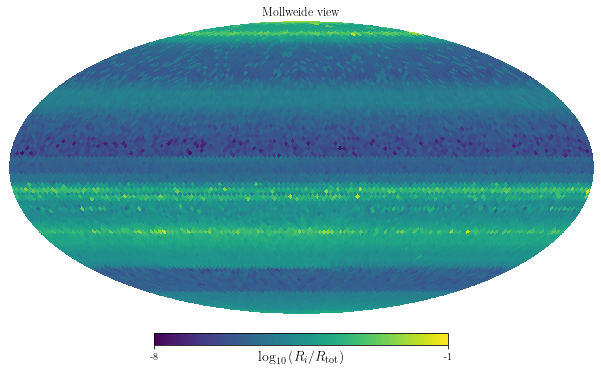

In [6]:
#fileN = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_-1.571_Mmc_1.0e-10_Rmc_3.06e9___fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
fileN = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-10_Rmc_3.0e9___AMC_NoTrace__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
nside=32
b_param = np.asarray([6.11e8, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = np.pi
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-8, den_avg=den_avg, NS_vel_T=NS_vel_T)

In [7]:
rho_amc = (3*1e-12 / (4*np.pi * (5280.0 / 3.086e13)**3))  #
transitT = AMC_CrossingTime(0.0, 1e-12, 0.00067, rho_amc)

In [8]:
transitT

52.572361673951846

24.982409539258132 21498.45332771016
3.101652313725437e+20


/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 360 deg 0.00'.
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 360 deg 0.00'.
  warnings.warn(


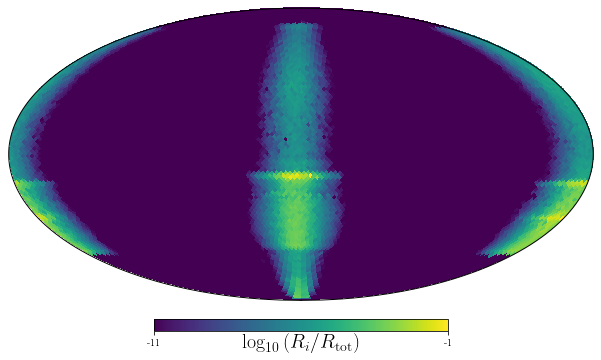

In [20]:
fileN = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-12_Rmc_5000.0__trace_trags__thetaCN___callback__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
nside=32
b_param = np.asarray([1e4, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = np.pi
is_axionstar = True
tag = "_AS_b_1e4km_"
sve=True
ShowPlots(fileN, nside, b_param, time, maxF=-1, minF=-11, den_avg=den_avg, NS_vel_T=NS_vel_T, is_axionstar=is_axionstar, tag=tag, sve=sve)

159.9888599809491 11508.657883567043
2.9784499059605484e+20


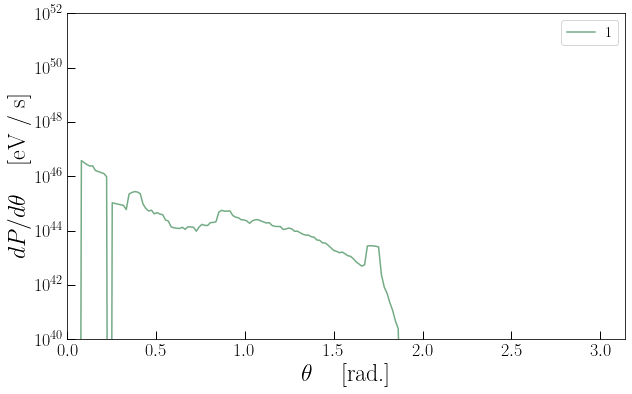

In [12]:
fileN = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_100000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-12_Rmc_5000.0__trace_trags__thetaCN___callback__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"

fileList = [fileN]
labels = [r"1", "2", "3"]
fileTag = ""
b_param = [np.asarray([0, 0.0, 0.0]), np.asarray([0, 0.0, 0.0]), np.asarray([0.0, 0.0, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
NS_vel_T = np.pi
is_axionstar = True
ymin=1e40
ymax=1e52
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.04, binTot=200, sve=False, fileTag=fileTag, den_avg=den_avg, NS_vel_T=NS_vel_T, is_axionstar=is_axionstar, ymin=ymin, ymax=ymax)

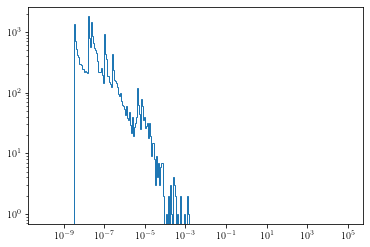

In [8]:
fileN = "../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_20000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-12_Rmc_5280.0___fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz"
histo_conv_probs(fileN)

In [9]:
a = np.load("../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_10000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-12_Rmc_5280.0___Trace__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz")

In [10]:
np.mean(np.abs(np.sum(a[:,18:21] * np.array([0,0,1]), axis=1)))

76111350.78487672

In [7]:
b = np.load("../src/results/Minicluster__MassAx_1.0e-5_ThetaM_0.0_rotPulsar_6.283_B0_1.0e14_rNS_10_MassNS_1_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_3.142_Mmc_1.0e-12_Rmc_5280.0___AxionStar_LowThresh1e-4__fixed_time_0.0_odeErr_1.0e-5_vxNS_0_vyNS_0_vzNS_0_.npz")
np.median(np.abs(np.sum(b[:,18:21] * np.array([0,0,1]), axis=1)))

66523831.40179427

In [12]:
b[:,18:21]

array([[-3.18727507e+03, -3.96050746e+03,  6.65238314e+07],
       [-3.18727507e+03, -3.96050746e+03,  6.65238314e+07],
       [-1.04648210e+03, -6.61806506e+03,  6.65238314e+07],
       ...,
       [-8.35921655e+03,  3.43805906e+03,  6.65238314e+07],
       [-9.37573451e+02, -3.11176165e+03,  6.65238314e+07],
       [-9.37573451e+02, -3.11176165e+03,  6.65238314e+07]])

In [13]:
a[:,18:21]

array([[ 2.04756366e+03, -4.47911250e+03,  7.61105663e+07],
       [-2.30426981e+03,  3.11966030e+03,  7.61109533e+07],
       [-7.34786096e+03, -7.15760323e+03,  7.61115635e+07],
       ...,
       [ 1.84000186e+03,  9.82003414e+03,  7.61109993e+07],
       [ 3.06837215e+03, -4.61504573e+03,  7.61117356e+07],
       [ 3.82383531e+03,  1.93985451e+03,  7.61107084e+07]])

 TESTS ABOVE, RESULTS BELOW 

4255798.039631398 144107431033498.38
2654.753737861838


/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 360 deg 0.00'.
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 360 deg 0.00'.
  warnings.warn(


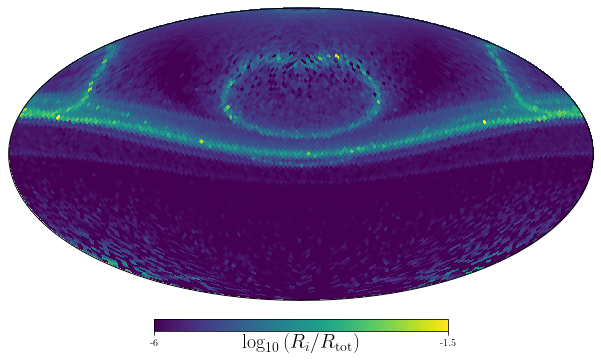

In [5]:
fileN = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_3000000_NS_Mag_3.0e-5_NS_Theta_0.0_Mmc_1.0e-17_Rmc_4.0e7__trace_trags__thetaCN___NFW__.npz"
nside=32
b_param = np.asarray([6.11e6, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.0
ShowPlots(fileN, nside, b_param, time, maxF=-1.5, minF=-6, den_avg=den_avg, NS_vel_T=NS_vel_T)

597777010.6740909 713461962992.4473
11.14214620903702


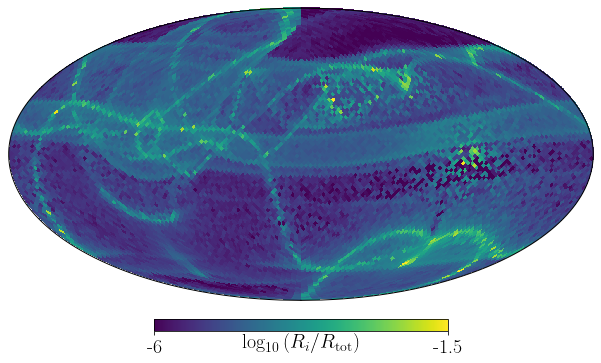

In [11]:
fileN = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_0.78_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
nside=32
b_param = np.asarray([6e8, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.78
ShowPlots(fileN, nside, b_param, time, maxF=-1.5, minF=-6, den_avg=den_avg, NS_vel_T=NS_vel_T)

597897200.8344676 594757593184.4196
11.135491623254952


/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 360 deg 0.00'.
  warnings.warn(
/Users/samuelwitte/.local/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 360 deg 0.00'.
  warnings.warn(


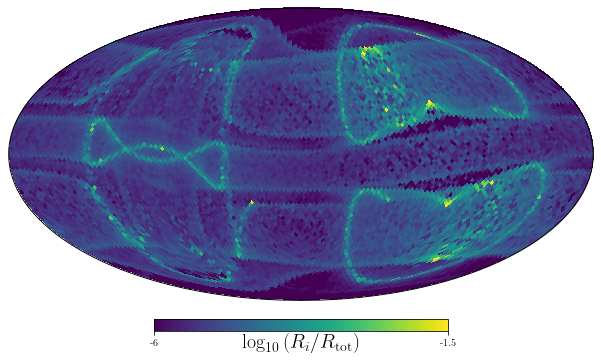

In [4]:
fileN = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_1.57_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
nside=32
b_param = np.asarray([6e8, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 1.57
ShowPlots(fileN, nside, b_param, time, maxF=-1.5, minF=-6, den_avg=den_avg, NS_vel_T=NS_vel_T, sve=True)

558346878.9750094 46227489503471.62
13.645978628209066


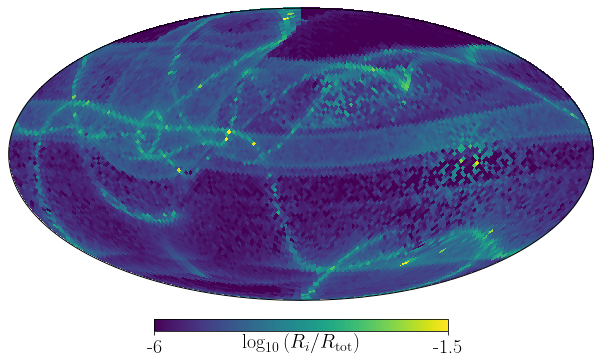

In [14]:
fileN = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_3.0e-5_NS_Theta_0.78_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
nside=32
b_param = np.asarray([6e8, 0.0, 0.0])
time = 0.0 # transitT / 2
den_avg = False
NS_vel_T = 0.78
ShowPlots(fileN, nside, b_param, time, maxF=-1.5, minF=-6, den_avg=den_avg, NS_vel_T=NS_vel_T)

597867506.76814 1016975870989.152
11.019521776278212
597777010.6740909 713461962992.4473
11.019448065061926
597897200.8344676 594757593184.4196
11.01948924668024


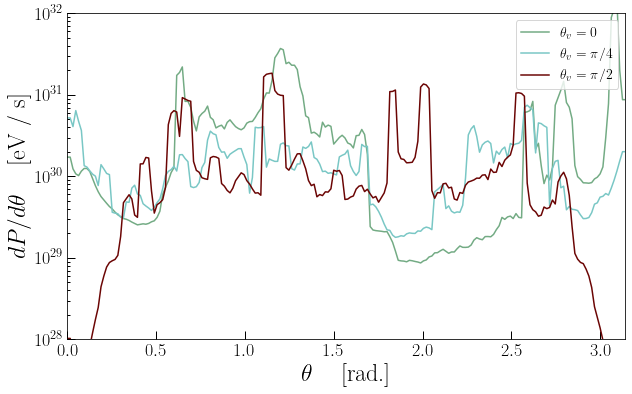

In [19]:
fileN1 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_0.0_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
fileN2 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_0.78_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
fileN3 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_1.57_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3]
labels = [r"$\theta_v = 0$", r"$\theta_v = \pi/4$", r"$\theta_v = \pi/2$"]
SuppFactor = [1, 1, 1]
fileTag = ""
b_param = [np.asarray([6e8, 0.0, 0.0]), np.asarray([6e8, 0.0, 0.0]), np.asarray([6e8, 0.0, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
NS_vel_T = [0.0, 0.78, 1.57]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.03, binTot=200, sve=False, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e32, ymin=1e28, sve_flux=sve_flux)

597867506.76814 1016975870989.152
11.019521776278212
597777010.6740909 713461962992.4473
11.019448065061926
23329984907556.004 122617587268616.39
0.0
16572550261988.906 111659142873128.89
0.0


IndexError: list index out of range

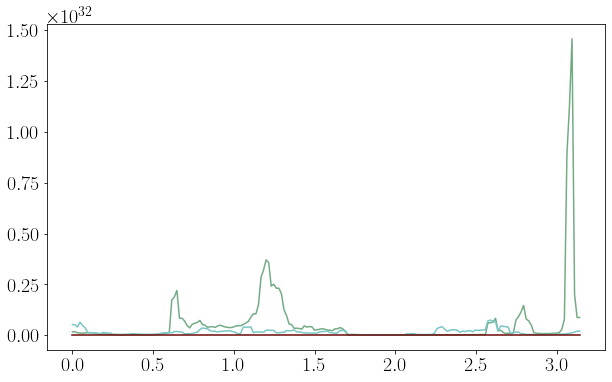

In [23]:
fileN1 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_0.0_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
fileN2 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_0.00067_NS_Theta_0.78_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
fileN3 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_3.0e-5_NS_Theta_1.57_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
fileN4 = "results/Minicluster__MassAx_2.6e-5_AxG_1.0e-14_ThetaM_0.2_rotPulsar_1.67_B0_1.6e14_rNS_10.0_MassNS_1.0_Ntrajs_1000000_NS_Mag_3.0e-5_NS_Theta_1.57_Mmc_1.0e-13_Rmc_8.6e8__trace_trags__thetaCN___NFW__.npz"
# fileList = [fileN1, fileN2, fileN3]
fileList = [fileN1, fileN2, fileN3, fileN4]
labels = [r"$\theta_v = 0$", r"$\theta_v = \pi/4$", r"$\theta_v = \pi/2$"]
SuppFactor = [1, 1, 1]
fileTag = ""
b_param = [np.asarray([6e8, 0.0, 0.0]), np.asarray([6e8, 0.0, 0.0]), np.asarray([1e10, 0.0, 0.0]), np.asarray([1e10, 0.0, 0.0])]
den_avg = [False, False, False]
time = 0.0 
# time = transitT / 8
sve_flux = False
NS_vel_T = [0.0, 0.78, 0.0, 0.78]
generate_diff_power_plots(fileList, b_param, time, labels, cutN=1.0, eps_theta=0.03, binTot=200, sve=False, fileTag=fileTag, SuppFactor=SuppFactor, den_avg=den_avg, NS_vel_T=NS_vel_T, ymax=1e32, ymin=1e28, sve_flux=sve_flux)